# Appendix C:Topic Modeling to Classification Modeling

## ADS 509: Final Project Code
## Team 4
### Zachariah Freitas and Brianne Bell
 

Since our data is organized into groups, we will build both a multinomial Logistic Regression classifier and a multinomial Naive Bayes classifier first. We will then report the accuracy of our models against our hold-out test set. 

Once that is complete, we will build NMF, LSA, and LDA topic models, which put our data into topic groups. We will then compare how well those topic models agree with our a priori groups.  

-- updated--
Since our data is organized into groups with overlap of groups ('terms') where each entry has 1-11 groups, we will first determine our own topic groups through topic modeling. 

Once our topic modeling is complete, we will use those results to develop classification models. These will be the multinomial Naive Bayes classifier and multinomial Logistic Regression classifier models. We will then report accuracy of our models against the hold out test set. 

## Import Libraries

In [1]:
# Import Libraries
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
# from collections import Counter 
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 
import textacy.preprocessing as tprep
from lexical_diversity import lex_div as ld

from ast import literal_eval

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix

import warnings  
warnings.filterwarnings('ignore')


## Helper Functions

In [2]:
# Add additional helper functions

# Stopwords
sw = stopwords.words("english")

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
# tw_punct = punctuation - {"#"} # Do this if there is punctuation you would like to ignore.

# Helper Functions - Cleaning data

def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

def remove_punctuation(text, punct_set=punctuation) : 
    """This function removes punctuation from a string."""
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return text.lower().strip().split() 

def remove_stop(tokens) :
    """This function removes stopwords from a list of tokens."""
    return([t for t in tokens if t.lower() not in sw])

def detokenize(list) : 
    """ Returning back a string from a list of tokens"""
    
    # modify this function to return string from tokens
    return(" ".join([str(e) for e in list]))
    
def prepare(text, pipeline) : 
    """ This fuction manages and executes other functions like a pipline. """
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

## Data ETL and EDA

In [3]:
# Get Imported Data
arxiv_data = pd.read_pickle('G:\\My Drive\\ADS-509_Final_Team_Project\\arxiv_data_2023_02_13.pkl')
arxiv_data

,titles,abstracts,terms
0,Reinforcement Learning from Multiple Sensors v...,"In many scenarios, observations from more than...",[cs.LG]
1,Interventional Causal Representation Learning,Causal representation learning seeks to extrac...,"[stat.ML, cs.LG]"
2,Self-Supervised Node Representation Learning v...,Self-supervised node representation learning a...,[cs.LG]
3,Out-of-Distribution Representation Learning fo...,Time series classification is an important pro...,"[cs.LG, cs.AI]"
4,Trading Information between Latents in Hierarc...,Variational Autoencoders (VAEs) were originall...,"[stat.ML, cs.CV, cs.IT, cs.LG, math.IT]"
...,...,...,...
64568,Plot 94 in ambiance X-Window,<PLOT > is a collection of routines to draw su...,"[cs.CV, cs.GR]"
64569,Automatic Face Recognition System Based on Loc...,We present an automatic face verification syst...,[cs.CV]
64570,Convexity Analysis of Snake Models Based on Ha...,This paper presents a convexity analysis for t...,"[cs.CV, cs.GR, I.4; I.4.6;I.4.8]"
64571,Semi-automatic vectorization of linear network...,A system for semi-automatic vectorization of l...,"[cs.CV, cs.MM, I.4.6]"


In [4]:
# Data Review
print(f"There are {len(arxiv_data)} rows in the dataset.\n")

total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicated titles.\n")

dedup_arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()].reset_index()
print(f"There are {len(dedup_arxiv_data)} rows in the deduplicated dataset.\n")

# There are some terms with occurrence as low as 1.
occur = sum(dedup_arxiv_data["terms"].value_counts() == 1)
print(f"There are {occur} terms with an occurrence of 1.\n")

# How many unique terms?
unique_terms = dedup_arxiv_data["terms"].astype('str').nunique()
print(f"There are {unique_terms} unique terms.\n")

There are 64573 rows in the dataset.

There are 14237 duplicated titles.

There are 50336 rows in the deduplicated dataset.

There are 2907 terms with an occurrence of 1.

There are 3961 unique terms.



In [5]:
columns = ['category_1', 'category_2', 'category_3',
          'category_4', 'category_5', 'category_6',
          'category_7', 'category_8', 'category_9',
          'category_10', 'category_11']

# Melt the categories to individual columns regardless of name or order.
df = dedup_arxiv_data.terms.apply(pd.Series)

# Name the columns for Clarity.
df.columns = columns

def add_dummies(df):
    uniqueValues = []
    for columnName in df:
        categories = df[columnName].unique().tolist()
        categories = [x for x in categories if x is not None]
        uniqueValues.extend(categories)
        uniqueValues = list(set(uniqueValues))

    print("Number of Categories:",len(uniqueValues))

    result_df = pd.concat([df,pd.DataFrame(columns = list(uniqueValues))])
    result_df.fillna(0, inplace = True)
    return result_df


cat = add_dummies(df)
cat



Number of Categories: 1382


,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,...,68T40,"37N30, 68T07","I.2.6, I.2.11",B.8.1,cs.IR,I.5.1; I.5.4; G.3; I.2.7; I.2.6,I.3.5; I.2.10,"62H17, 62M40",68T50,I.4.10
0,cs.LG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,stat.ML,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,cs.LG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,cs.LG,cs.AI,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,stat.ML,cs.CV,cs.IT,cs.LG,math.IT,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50331,cs.CV,cs.GR,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50332,cs.CV,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50333,cs.CV,cs.GR,I.4; I.4.6;I.4.8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50334,cs.CV,cs.MM,I.4.6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Mark each of the categories with 1 if they exist.

# columns1 = ['category_1']

for col in columns:
    row = 0
    for row, category in enumerate(cat[col]):
        # print(category)
        if category != 0:
            cat.loc[row, category] = 1

# # Create New Dataframe with dummies appended.
description_category_new = pd.concat([dedup_arxiv_data['titles'],dedup_arxiv_data['abstracts'], 
dedup_arxiv_data['terms'], cat.iloc[:,11:]],
                                    axis=1)

# Drop the test Column
# description_category_new = description_category_new.drop(columns=['test'])

description_category_new.head()

,titles,abstracts,terms,cond-mat.mtrl-sci,"I.4.m, I.5.4, I.5.1, I.2.1","62H22, 62H30, 60-04, 91C20",eess.SP,I.2.5,68T07 (Primary) 90C08 (Secondary),"62M10, 91B84",...,68T40,"37N30, 68T07","I.2.6, I.2.11",B.8.1,cs.IR,I.5.1; I.5.4; G.3; I.2.7; I.2.6,I.3.5; I.2.10,"62H17, 62M40",68T50,I.4.10
0,Reinforcement Learning from Multiple Sensors v...,"In many scenarios, observations from more than...",[cs.LG],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Interventional Causal Representation Learning,Causal representation learning seeks to extrac...,"[stat.ML, cs.LG]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Self-Supervised Node Representation Learning v...,Self-supervised node representation learning a...,[cs.LG],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Out-of-Distribution Representation Learning fo...,Time series classification is an important pro...,"[cs.LG, cs.AI]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Trading Information between Latents in Hierarc...,Variational Autoencoders (VAEs) were originall...,"[stat.ML, cs.CV, cs.IT, cs.LG, math.IT]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
cat.isnull().values.any()

False

In [8]:
cat.isnull().sum()

category_1                         0
category_2                         0
category_3                         0
category_4                         0
category_5                         0
                                  ..
I.5.1; I.5.4; G.3; I.2.7; I.2.6    0
I.3.5; I.2.10                      0
62H17, 62M40                       0
68T50                              0
I.4.10                             0
Length: 1393, dtype: int64

In [9]:
# Let's get the columns with the highest counts
bar_plot = pd.DataFrame()
bar_plot['cat'] = description_category_new.columns[3:]
bar_plot['count'] = description_category_new.iloc[:,3:].sum().values
bar_plot.sort_values(['count'], inplace=True, ascending=False)
bar_plot.reset_index(inplace=True, drop=True)
bar_plot.head()

,cat,count
0,cs.LG,28902
1,cs.CV,27981
2,stat.ML,11087
3,cs.AI,10249
4,cs.RO,2037


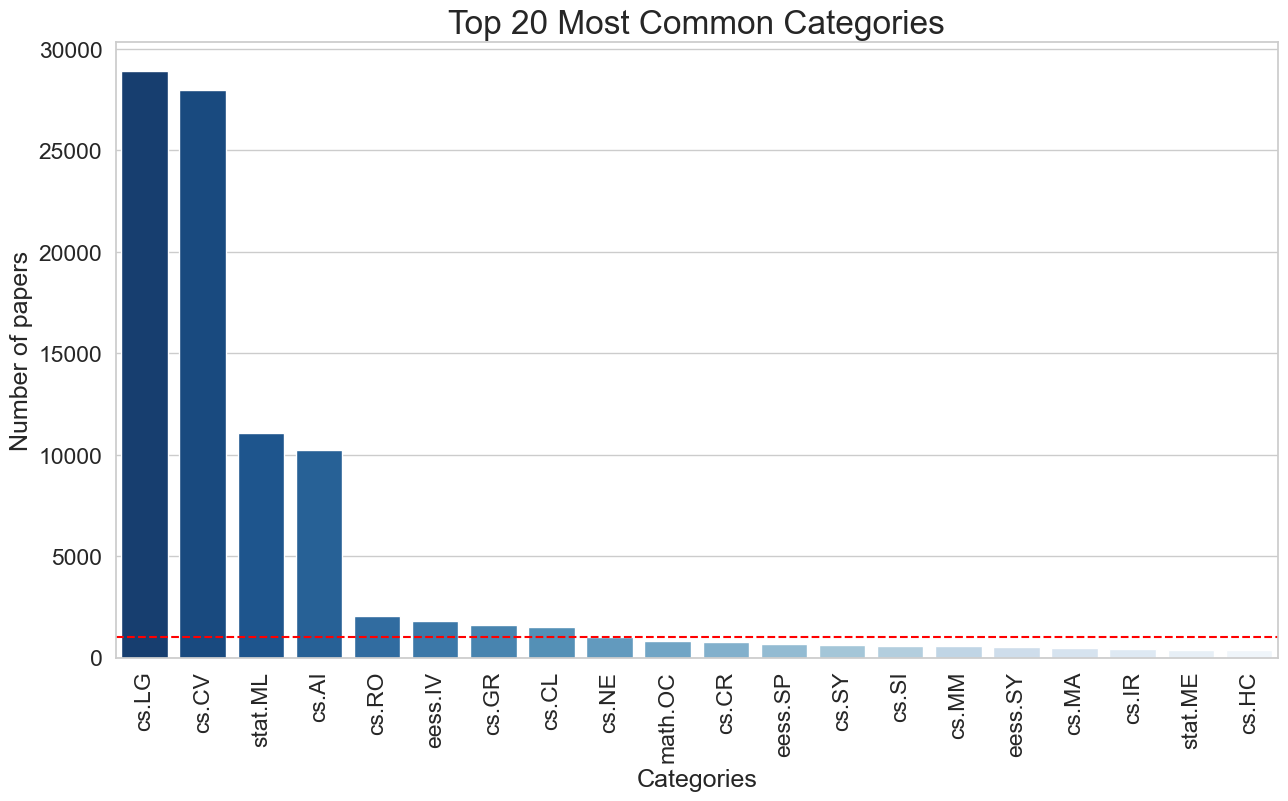

In [31]:
# Plot the Top N Most Common Categories.

top_n = 20
threshold = 1000

plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 


pal = sns.color_palette("Blues_r", len(bar_plot.head(top_n)))
rank = bar_plot['count'].head(top_n).argsort().argsort()  

sns.barplot(data = bar_plot.head(top_n), x='cat', y = 'count', palette=np.array(pal[::-1])[rank])
plt.axhline(threshold, ls='--', c='red')
plt.title(f"Top {top_n} Most Common Categories", fontsize=24)
plt.ylabel('Number of papers', fontsize=18)
plt.xlabel('Categories', fontsize=18)
plt.xticks(rotation='vertical')

plt.show()

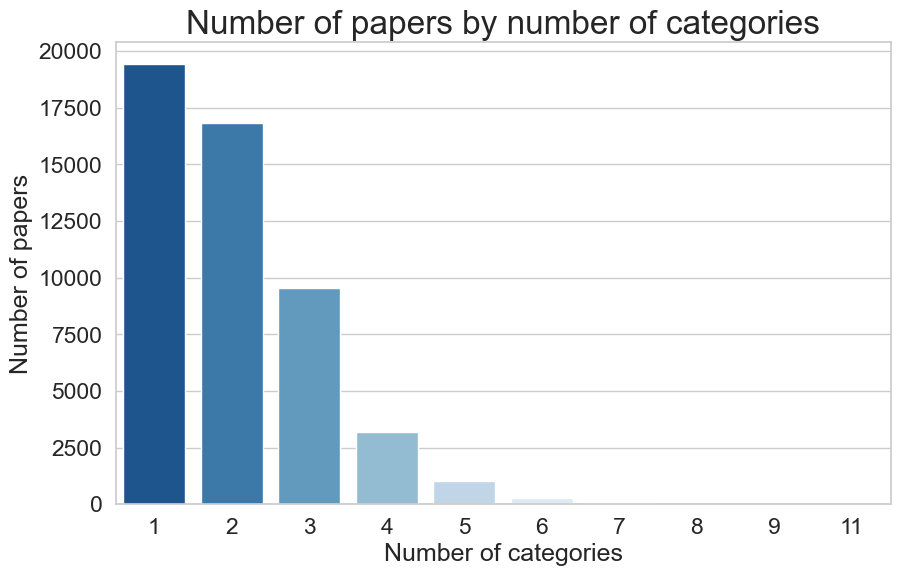

In [32]:
rowSums = description_category_new.iloc[:,3:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()

sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 
plt.figure(figsize=(10,6))

pal = sns.color_palette("Blues_r")

sns.barplot( x = multiLabel_counts.index, y = multiLabel_counts.values, palette=pal)
plt.title("Number of papers by number of categories", fontsize=24)
plt.ylabel('Number of papers', fontsize=18)
plt.xlabel('Number of categories', fontsize=18)

plt.show()

In [33]:
# Consolidate Categories Based ON 1000 Term Threashold. Put everything else in Other bucket.

main_categories = pd.DataFrame()
main_categories = bar_plot[bar_plot['count']>1000]
categories = main_categories['cat'].values
categories = np.append(categories,'Others')
not_category = []
description_category_new['Others'] = 0

description_category_new_consolidated = description_category_new.copy()

for i in description_category_new_consolidated.columns[3:]:
    if i not in categories:
        description_category_new_consolidated['Others'][description_category_new_consolidated[i] == 1] = 1
        not_category.append(i)

description_category_new_consolidated.drop(not_category, axis=1, inplace=True)


In [34]:
description_category_new_consolidated

,titles,abstracts,terms,cs.CV,cs.AI,cs.CL,eess.IV,stat.ML,cs.LG,cs.NE,cs.RO,cs.GR,Others
0,Reinforcement Learning from Multiple Sensors v...,"In many scenarios, observations from more than...",[cs.LG],0,0,0,0,0,1,0,0,0,0
1,Interventional Causal Representation Learning,Causal representation learning seeks to extrac...,"[stat.ML, cs.LG]",0,0,0,0,1,1,0,0,0,0
2,Self-Supervised Node Representation Learning v...,Self-supervised node representation learning a...,[cs.LG],0,0,0,0,0,1,0,0,0,0
3,Out-of-Distribution Representation Learning fo...,Time series classification is an important pro...,"[cs.LG, cs.AI]",0,1,0,0,0,1,0,0,0,0
4,Trading Information between Latents in Hierarc...,Variational Autoencoders (VAEs) were originall...,"[stat.ML, cs.CV, cs.IT, cs.LG, math.IT]",1,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50331,Plot 94 in ambiance X-Window,<PLOT > is a collection of routines to draw su...,"[cs.CV, cs.GR]",1,0,0,0,0,0,0,0,1,0
50332,Automatic Face Recognition System Based on Loc...,We present an automatic face verification syst...,[cs.CV],1,0,0,0,0,0,0,0,0,0
50333,Convexity Analysis of Snake Models Based on Ha...,This paper presents a convexity analysis for t...,"[cs.CV, cs.GR, I.4; I.4.6;I.4.8]",1,0,0,0,0,0,0,0,1,1
50334,Semi-automatic vectorization of linear network...,A system for semi-automatic vectorization of l...,"[cs.CV, cs.MM, I.4.6]",1,0,0,0,0,0,0,0,0,1


In [35]:
description_category_new_consolidated.describe().T

,count,mean,std,min,25%,50%,75%,max
cs.CV,50336.0,0.555884,0.496872,0.0,0.0,1.0,1.0,1.0
cs.AI,50336.0,0.203612,0.402687,0.0,0.0,0.0,0.0,1.0
cs.CL,50336.0,0.029641,0.169596,0.0,0.0,0.0,0.0,1.0
eess.IV,50336.0,0.035382,0.184746,0.0,0.0,0.0,0.0,1.0
stat.ML,50336.0,0.220260,0.414426,0.0,0.0,0.0,0.0,1.0
cs.LG,50336.0,0.574182,0.494471,0.0,0.0,1.0,1.0,1.0
cs.NE,50336.0,0.020562,0.141913,0.0,0.0,0.0,0.0,1.0
cs.RO,50336.0,0.040468,0.197056,0.0,0.0,0.0,0.0,1.0
cs.GR,50336.0,0.032084,0.176226,0.0,0.0,0.0,0.0,1.0
Others,50336.0,0.212353,0.408977,0.0,0.0,0.0,0.0,1.0


## Normalize and Clean Text


In [36]:
# Clean and Tokenize Data
df = description_category_new_consolidated.copy()

df["titles_abstracts"] = df["titles"] + df["abstracts"]


my_pipeline = [normalize, remove_punctuation, tokenize, remove_stop, detokenize]
df["summaries"] = df["titles_abstracts"].apply(prepare, pipeline=my_pipeline)

cols = ['terms','titles', 'abstracts', 'summaries',  
'cs.LG','cs.CV','stat.ML','cs.AI','cs.RO','eess.IV','cs.GR', 
 'cs.CL','cs.NE','Others']
df = df[cols]
df

,terms,titles,abstracts,summaries,cs.LG,cs.CV,stat.ML,cs.AI,cs.RO,eess.IV,cs.GR,cs.CL,cs.NE,Others
0,[cs.LG],Reinforcement Learning from Multiple Sensors v...,"In many scenarios, observations from more than...",reinforcement learning multiple sensors via jo...,1,0,0,0,0,0,0,0,0,0
1,"[stat.ML, cs.LG]",Interventional Causal Representation Learning,Causal representation learning seeks to extrac...,interventional causal representation learningc...,1,0,1,0,0,0,0,0,0,0
2,[cs.LG],Self-Supervised Node Representation Learning v...,Self-supervised node representation learning a...,selfsupervised node representation learning vi...,1,0,0,0,0,0,0,0,0,0
3,"[cs.LG, cs.AI]",Out-of-Distribution Representation Learning fo...,Time series classification is an important pro...,outofdistribution representation learning time...,1,0,0,1,0,0,0,0,0,0
4,"[stat.ML, cs.CV, cs.IT, cs.LG, math.IT]",Trading Information between Latents in Hierarc...,Variational Autoencoders (VAEs) were originall...,trading information latents hierarchical varia...,1,1,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50331,"[cs.CV, cs.GR]",Plot 94 in ambiance X-Window,<PLOT > is a collection of routines to draw su...,plot 94 ambiance xwindowplot collection routin...,0,1,0,0,0,0,1,0,0,0
50332,[cs.CV],Automatic Face Recognition System Based on Loc...,We present an automatic face verification syst...,automatic face recognition system based local ...,0,1,0,0,0,0,0,0,0,0
50333,"[cs.CV, cs.GR, I.4; I.4.6;I.4.8]",Convexity Analysis of Snake Models Based on Ha...,This paper presents a convexity analysis for t...,convexity analysis snake models based hamilton...,0,1,0,0,0,0,1,0,0,1
50334,"[cs.CV, cs.MM, I.4.6]",Semi-automatic vectorization of linear network...,A system for semi-automatic vectorization of l...,semiautomatic vectorization linear networks ra...,0,1,0,0,0,0,0,0,0,1


In [37]:
y = df.columns[4:]
y

Index(['cs.LG', 'cs.CV', 'stat.ML', 'cs.AI', 'cs.RO', 'eess.IV', 'cs.GR',
       'cs.CL', 'cs.NE', 'Others'],
      dtype='object')

In [38]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(df.columns[4:])
y

array([[1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]])

In [39]:
multilabel.classes_

array(['.', 'A', 'C', 'E', 'G', 'I', 'L', 'M', 'N', 'O', 'R', 'V', 'a',
       'c', 'e', 'h', 'r', 's', 't'], dtype=object)

In [40]:
df

,terms,titles,abstracts,summaries,cs.LG,cs.CV,stat.ML,cs.AI,cs.RO,eess.IV,cs.GR,cs.CL,cs.NE,Others
0,[cs.LG],Reinforcement Learning from Multiple Sensors v...,"In many scenarios, observations from more than...",reinforcement learning multiple sensors via jo...,1,0,0,0,0,0,0,0,0,0
1,"[stat.ML, cs.LG]",Interventional Causal Representation Learning,Causal representation learning seeks to extrac...,interventional causal representation learningc...,1,0,1,0,0,0,0,0,0,0
2,[cs.LG],Self-Supervised Node Representation Learning v...,Self-supervised node representation learning a...,selfsupervised node representation learning vi...,1,0,0,0,0,0,0,0,0,0
3,"[cs.LG, cs.AI]",Out-of-Distribution Representation Learning fo...,Time series classification is an important pro...,outofdistribution representation learning time...,1,0,0,1,0,0,0,0,0,0
4,"[stat.ML, cs.CV, cs.IT, cs.LG, math.IT]",Trading Information between Latents in Hierarc...,Variational Autoencoders (VAEs) were originall...,trading information latents hierarchical varia...,1,1,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50331,"[cs.CV, cs.GR]",Plot 94 in ambiance X-Window,<PLOT > is a collection of routines to draw su...,plot 94 ambiance xwindowplot collection routin...,0,1,0,0,0,0,1,0,0,0
50332,[cs.CV],Automatic Face Recognition System Based on Loc...,We present an automatic face verification syst...,automatic face recognition system based local ...,0,1,0,0,0,0,0,0,0,0
50333,"[cs.CV, cs.GR, I.4; I.4.6;I.4.8]",Convexity Analysis of Snake Models Based on Ha...,This paper presents a convexity analysis for t...,convexity analysis snake models based hamilton...,0,1,0,0,0,0,1,0,0,1
50334,"[cs.CV, cs.MM, I.4.6]",Semi-automatic vectorization of linear network...,A system for semi-automatic vectorization of l...,semiautomatic vectorization linear networks ra...,0,1,0,0,0,0,0,0,0,1


## Test Train Split

In [41]:
df.columns[4:]

Index(['cs.LG', 'cs.CV', 'stat.ML', 'cs.AI', 'cs.RO', 'eess.IV', 'cs.GR',
       'cs.CL', 'cs.NE', 'Others'],
      dtype='object')

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df['summaries'], 
                                                    df[df.columns[4:]], 
                                                    test_size=0.3, 
                                                    random_state=43, 
                                                    shuffle=True)
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

## Classification Modeling

In [43]:
# Logistic Regression

LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))])
accuracy = 0
for category in df.columns[4:]:
    print('**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    LR_pipeline.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = LR_pipeline.predict(X_test)
    accuracy = accuracy + accuracy_score(y_test[category], prediction)
    print('AUC ROC score is {}'.format(roc_auc_score(y_test[category],prediction)))
    conf_mat = confusion_matrix(
        y_test[category], prediction
        )
    print(conf_mat)
    print("\n")
    print("-"*40)

print('Test averaged AUC ROC is {}'.format(accuracy/len(df.columns[4:])))

**Processing cs.LG titles...**
AUC ROC score is 0.8641801493911652
[[5618  862]
 [1195 7426]]


----------------------------------------
**Processing cs.CV titles...**
AUC ROC score is 0.9410568098526846
[[6293  348]
 [ 554 7906]]


----------------------------------------
**Processing stat.ML titles...**
AUC ROC score is 0.7079844778699906
[[10816   948]
 [ 1680  1657]]


----------------------------------------
**Processing cs.AI titles...**
AUC ROC score is 0.5957771482700119
[[11377   621]
 [ 2348   755]]


----------------------------------------
**Processing cs.RO titles...**
AUC ROC score is 0.5368053608615541
[[14475    33]
 [  548    45]]


----------------------------------------
**Processing eess.IV titles...**
AUC ROC score is 0.5
[[14528     0]
 [  573     0]]


----------------------------------------
**Processing cs.GR titles...**
AUC ROC score is 0.5730128954560639
[[14570    49]
 [  410    72]]


----------------------------------------
**Processing cs.CL titles...**
A

In [44]:
# Multinomial Naive Bayes

NB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)))])
accuracy = 0
for category in df.columns[4:]:
    print('**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    NB_pipeline.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = NB_pipeline.predict(X_test)
    accuracy = accuracy + accuracy_score(y_test[category], prediction)
    print('AUC ROC is {}'.format(roc_auc_score(y_test[category],prediction)))
    conf_mat = confusion_matrix(
        y_test[category], prediction
        )
    print(conf_mat)
    print("\n")
    print("-"*40)


print('Test averaged AUC ROC is {}'.format(accuracy/len(df.columns[4:])))

**Processing cs.LG titles...**
AUC ROC is 0.7985542588368053
[[4318 2162]
 [ 597 8024]]


----------------------------------------
**Processing cs.CV titles...**
AUC ROC is 0.8845962362898578
[[5255 1386]
 [ 187 8273]]


----------------------------------------
**Processing stat.ML titles...**
AUC ROC is 0.5
[[11764     0]
 [ 3337     0]]


----------------------------------------
**Processing cs.AI titles...**
AUC ROC is 0.5
[[11998     0]
 [ 3103     0]]


----------------------------------------
**Processing cs.RO titles...**
AUC ROC is 0.5
[[14508     0]
 [  593     0]]


----------------------------------------
**Processing eess.IV titles...**
AUC ROC is 0.5
[[14528     0]
 [  573     0]]


----------------------------------------
**Processing cs.GR titles...**
AUC ROC is 0.5
[[14619     0]
 [  482     0]]


----------------------------------------
**Processing cs.CL titles...**
AUC ROC is 0.5
[[14657     0]
 [  444     0]]


----------------------------------------
**Processing c

## Topic Modeling

In [48]:
# Helper Functions

# add any additional libaries you need here

import seaborn as sns
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [54]:
# Count the words
count_text_vectorizer = CountVectorizer(stop_words=list(sw), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df['summaries'])
print(count_text_vectors.shape)

(50336, 23148)


In [55]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(sw), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['summaries'])
print(tfidf_text_vectors.shape)

(50336, 23148)


### Fitting a Non-Negative Matrix Factorization Model - NMF

In [58]:
nmf_text_model = NMF(n_components=10, random_state=314)
W_nmf_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_nmf_text_matrix = nmf_text_model.components_

In [74]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=6)


Topic 00
  reinforcement (1.33)
  policy (1.24)
  rl (1.12)
  learning (1.01)
  algorithm (0.58)
  algorithms (0.56)

Topic 01
  image (1.83)
  images (1.18)
  adversarial (0.80)
  generation (0.51)
  generative (0.51)
  neural (0.47)

Topic 02
  graph (4.92)
  graphs (1.46)
  node (1.35)
  gnns (1.13)
  neural (1.06)
  networks (0.94)

Topic 03
  point (4.62)
  3d (4.53)
  cloud (2.71)
  clouds (1.81)
  shape (1.12)
  2d (0.90)

Topic 04
  object (3.74)
  detection (3.46)
  objects (1.10)
  detectors (0.66)
  detector (0.60)
  tracking (0.51)

Topic 05
  series (2.54)
  time (2.48)
  forecasting (1.01)
  data (0.67)
  model (0.52)
  neural (0.52)

Topic 06
  depth (6.17)
  estimation (2.56)
  monocular (1.71)
  pose (1.02)
  stereo (0.85)
  camera (0.80)

Topic 07
  video (2.37)
  temporal (0.97)
  attention (0.97)
  transformer (0.76)
  action (0.70)
  videos (0.67)

Topic 08
  data (1.31)
  learning (1.28)
  domain (0.59)
  models (0.59)
  representation (0.56)
  training (0.52)

T

Original Topic - cs.LG


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.LG,,,,,,,,,,
0,151,4026,530,2483,3574,457,1527,3820,2689,2177
1,6495,2140,3770,595,939,3371,289,1353,9404,546


Column %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.LG,,,,,,,,,,
0,2%,65%,12%,81%,79%,12%,84%,74%,22%,80%
1,98%,35%,88%,19%,21%,88%,16%,26%,78%,20%


Total %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.LG,,,,,,,,,,
0,0%,8%,1%,5%,7%,1%,3%,8%,5%,4%
1,13%,4%,7%,1%,2%,7%,1%,3%,19%,1%




Original Topic - cs.CV


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.CV,,,,,,,,,,
0,6329,698,3542,111,195,3316,90,542,7464,68
1,317,5468,758,2967,4318,512,1726,4631,4629,2655


Column %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.CV,,,,,,,,,,
0,95%,11%,82%,4%,4%,87%,5%,10%,62%,2%
1,5%,89%,18%,96%,96%,13%,95%,90%,38%,98%


Total %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.CV,,,,,,,,,,
0,13%,1%,7%,0%,0%,7%,0%,1%,15%,0%
1,1%,11%,2%,6%,9%,1%,3%,9%,9%,5%




Original Topic - stat.ML


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
stat.ML,,,,,,,,,,
0,3707,5572,3061,2954,4350,2100,1732,4958,8213,2602
1,2939,594,1239,124,163,1728,84,215,3880,121


Column %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
stat.ML,,,,,,,,,,
0,56%,90%,71%,96%,96%,55%,95%,96%,68%,96%
1,44%,10%,29%,4%,4%,45%,5%,4%,32%,4%


Total %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
stat.ML,,,,,,,,,,
0,7%,11%,6%,6%,9%,4%,3%,10%,16%,5%
1,6%,1%,2%,0%,0%,3%,0%,0%,8%,0%




Original Topic - cs.AI


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.AI,,,,,,,,,,
0,3583,5327,3214,2805,4012,3196,1672,4330,9488,2460
1,3063,839,1086,273,501,632,144,843,2605,263


Column %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.AI,,,,,,,,,,
0,54%,86%,75%,91%,89%,83%,92%,84%,78%,90%
1,46%,14%,25%,9%,11%,17%,8%,16%,22%,10%


Total %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.AI,,,,,,,,,,
0,7%,11%,6%,6%,8%,6%,3%,9%,19%,5%
1,6%,2%,2%,1%,1%,1%,0%,2%,5%,1%




Original Topic - cs.RO


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.RO,,,,,,,,,,
0,5911,6114,4251,2817,4254,3799,1599,5028,11897,2629
1,735,52,49,261,259,29,217,145,196,94


Column %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.RO,,,,,,,,,,
0,89%,99%,99%,92%,94%,99%,88%,97%,98%,97%
1,11%,1%,1%,8%,6%,1%,12%,3%,2%,3%


Total %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.RO,,,,,,,,,,
0,12%,12%,8%,6%,8%,8%,3%,10%,24%,5%
1,1%,0%,0%,1%,1%,0%,0%,0%,0%,0%




Original Topic - eess.IV


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
eess.IV,,,,,,,,,,
0,6637,5590,4260,2915,4284,3772,1723,5009,11836,2529
1,9,576,40,163,229,56,93,164,257,194


Column %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
eess.IV,,,,,,,,,,
0,100%,91%,99%,95%,95%,99%,95%,97%,98%,93%
1,0%,9%,1%,5%,5%,1%,5%,3%,2%,7%


Total %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
eess.IV,,,,,,,,,,
0,13%,11%,8%,6%,9%,7%,3%,10%,24%,5%
1,0%,1%,0%,0%,0%,0%,0%,0%,1%,0%




Original Topic - cs.GR


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.GR,,,,,,,,,,
0,6620,5603,4268,2621,4462,3793,1730,4979,11971,2674
1,26,563,32,457,51,35,86,194,122,49


Column %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.GR,,,,,,,,,,
0,100%,91%,99%,85%,99%,99%,95%,96%,99%,98%
1,0%,9%,1%,15%,1%,1%,5%,4%,1%,2%


Total %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.GR,,,,,,,,,,
0,13%,11%,8%,5%,9%,8%,3%,10%,24%,5%
1,0%,1%,0%,1%,0%,0%,0%,0%,0%,0%




Original Topic - cs.CL


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.CL,,,,,,,,,,
0,6570,5916,4212,3070,4477,3786,1813,4772,11535,2693
1,76,250,88,8,36,42,3,401,558,30


Column %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.CL,,,,,,,,,,
0,99%,96%,98%,100%,99%,99%,100%,92%,95%,99%
1,1%,4%,2%,0%,1%,1%,0%,8%,5%,1%


Total %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.CL,,,,,,,,,,
0,13%,12%,8%,6%,9%,8%,4%,9%,23%,5%
1,0%,0%,0%,0%,0%,0%,0%,1%,1%,0%




Original Topic - cs.NE


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.NE,,,,,,,,,,
0,6452,6033,4213,3066,4463,3675,1810,5115,11783,2691
1,194,133,87,12,50,153,6,58,310,32


Column %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.NE,,,,,,,,,,
0,97%,98%,98%,100%,99%,96%,100%,99%,97%,99%
1,3%,2%,2%,0%,1%,4%,0%,1%,3%,1%


Total %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.NE,,,,,,,,,,
0,13%,12%,8%,6%,9%,7%,4%,10%,23%,5%
1,0%,0%,0%,0%,0%,0%,0%,0%,1%,0%




Original Topic - Others


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
Others,,,,,,,,,,
0,4648,5204,2882,2781,4130,2481,1679,4468,8898,2476
1,1998,962,1418,297,383,1347,137,705,3195,247


Column %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
Others,,,,,,,,,,
0,70%,84%,67%,90%,92%,65%,92%,86%,74%,91%
1,30%,16%,33%,10%,8%,35%,8%,14%,26%,9%


Total %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
Others,,,,,,,,,,
0,9%,10%,6%,6%,8%,5%,3%,9%,18%,5%
1,4%,2%,3%,1%,1%,3%,0%,1%,6%,0%


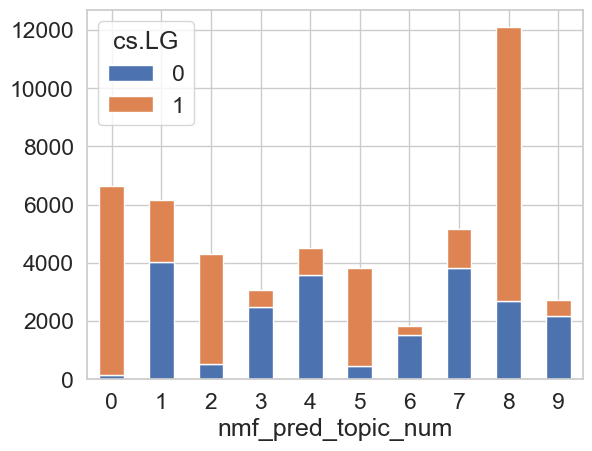

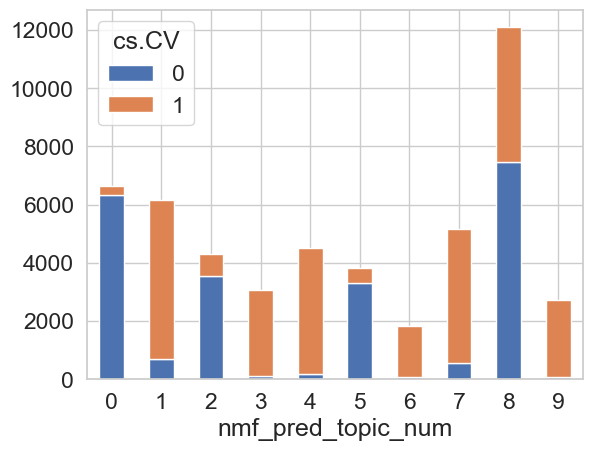

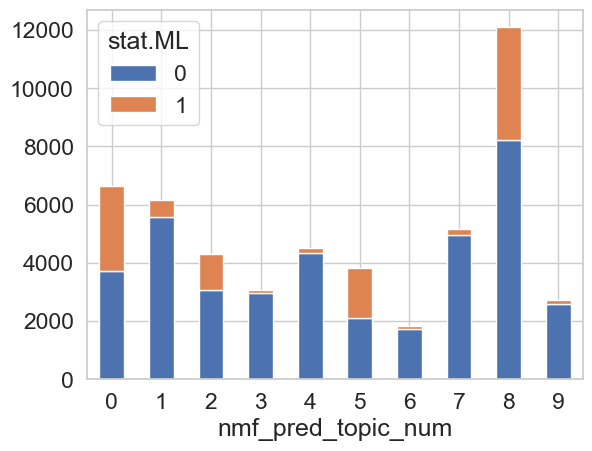

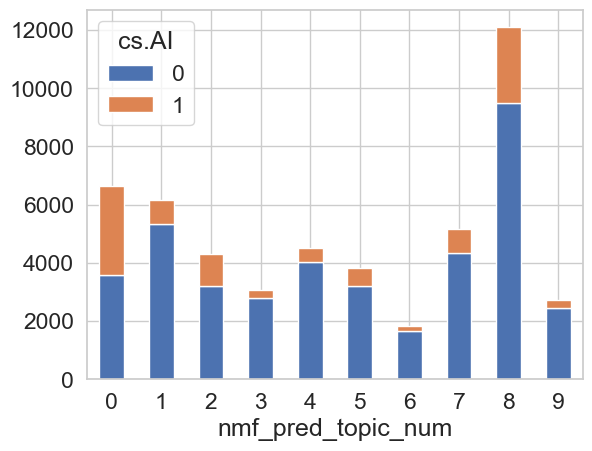

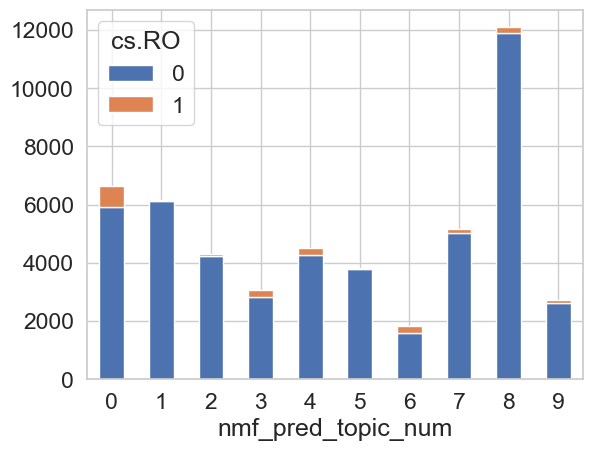

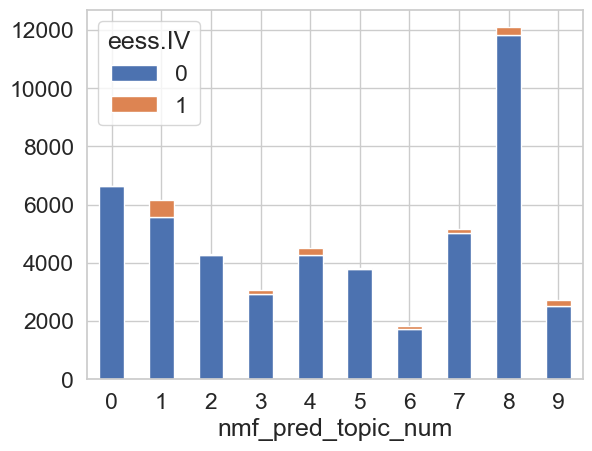

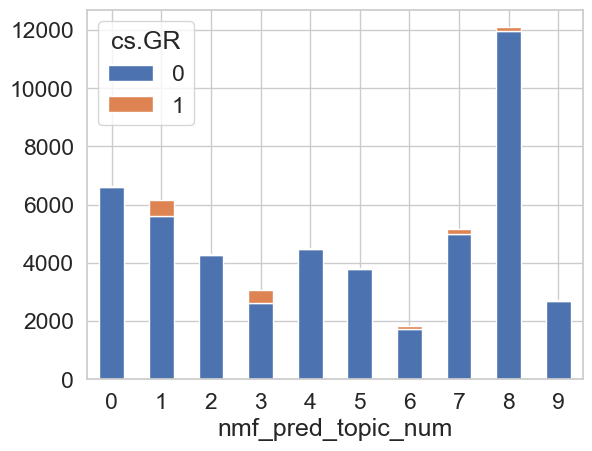

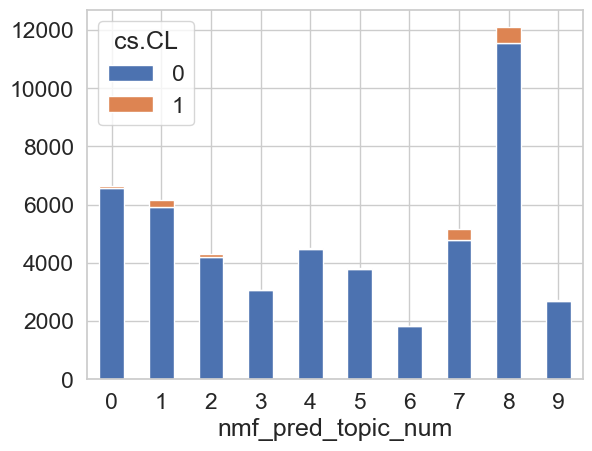

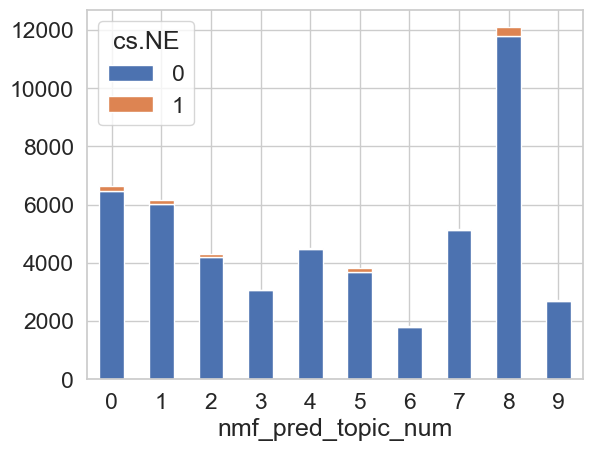

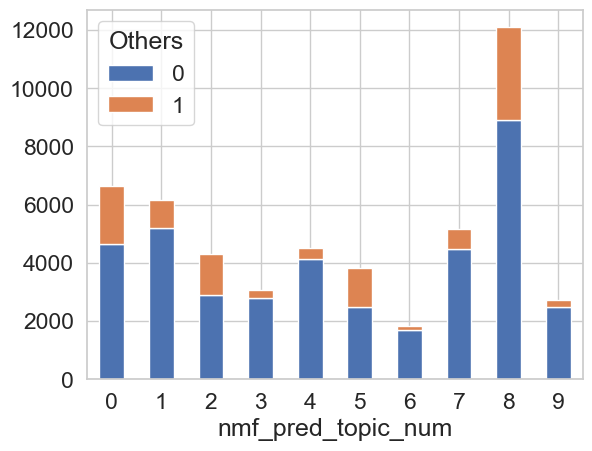

In [112]:
# Evaluate the Categories
df_new = df.copy()

# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in W_nmf_text_matrix]

# Add to the df
df_new['nmf_pred_topic_num'] = predicted_topics

# Create Crosstab
for _, col in enumerate(df_new.columns[4:14]):
    print("Original Topic -", col)
    chart_df = pd.crosstab(df_new["nmf_pred_topic_num"], df_new[col],  dropna=False)
    display(chart_df.plot(kind="bar", stacked=True, rot=0))
    print("Counts:")
    display(pd.crosstab(df_new[col], df_new["nmf_pred_topic_num"], dropna=False))
    print("Column %:")
    display(pd.crosstab(df_new[col], df_new["nmf_pred_topic_num"], dropna=False, normalize='columns').style.format("{:.0%}"))
    print("Total %:")
    display(pd.crosstab(df_new[col], df_new["nmf_pred_topic_num"], dropna=False, normalize='all').style.format("{:.0%}"))
    print('\n')

### Fitting an LSA Model - LSA

In [113]:
# Your code here
lsa_text_model = TruncatedSVD(n_components=10, n_iter=14, random_state=42)
W_lsa_text_matrix = lsa_text_model.fit_transform(tfidf_text_vectors)
H_lsa_text_matrix = lsa_text_model.components_

In [115]:
display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=5)


Topic 00
  learning (0.49)
  data (0.38)
  image (0.34)
  model (0.33)
  graph (0.29)

Topic 01
  3d (7.06)
  object (6.35)
  detection (4.88)
  point (4.36)
  image (3.57)

Topic 02
  graph (17.54)
  graphs (5.13)
  node (4.89)
  gnns (4.08)
  neural (3.78)

Topic 03
  point (30.04)
  3d (29.24)
  cloud (17.63)
  graph (15.85)
  clouds (11.79)

Topic 04
  object (60.04)
  detection (57.44)
  graph (27.03)
  objects (15.96)
  detectors (11.13)

Topic 05
  series (18.95)
  time (17.51)
  data (11.87)
  detection (7.44)
  forecasting (7.28)

Topic 06
  depth (19.41)
  estimation (8.32)
  video (7.19)
  monocular (5.46)
  pose (4.24)

Topic 07
  video (38.14)
  temporal (18.14)
  attention (13.35)
  action (13.19)
  point (12.86)

Topic 08
  data (6.34)
  domain (5.61)
  learning (4.61)
  representation (4.21)
  representations (3.48)

Topic 09
  segmentation (9.14)
  depth (5.50)
  semantic (3.66)
  domain (3.53)
  learning (3.17)


Original Topic - cs.LG


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.LG,,,,,,,,,,
0,17499,383,99,934,750,73,795,718,47,136
1,25303,54,1717,181,163,1167,109,113,67,28


Column %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.LG,,,,,,,,,,
0,41%,88%,5%,84%,82%,6%,88%,86%,41%,83%
1,59%,12%,95%,16%,18%,94%,12%,14%,59%,17%


Total %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.LG,,,,,,,,,,
0,35%,1%,0%,2%,1%,0%,2%,1%,0%,0%
1,50%,0%,3%,0%,0%,2%,0%,0%,0%,0%




Original Topic - cs.CV


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.CV,,,,,,,,,,
0,19438,1,1637,22,12,1189,14,4,36,2
1,23364,436,179,1093,901,51,890,827,78,162


Column %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.CV,,,,,,,,,,
0,45%,0%,90%,2%,1%,96%,2%,0%,32%,1%
1,55%,100%,10%,98%,99%,4%,98%,100%,68%,99%


Total %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.CV,,,,,,,,,,
0,39%,0%,3%,0%,0%,2%,0%,0%,0%,0%
1,46%,1%,0%,2%,2%,0%,2%,2%,0%,0%




Original Topic - stat.ML


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
stat.ML,,,,,,,,,,
0,33027,434,1287,1087,889,563,889,824,90,159
1,9775,3,529,28,24,677,15,7,24,5


Column %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
stat.ML,,,,,,,,,,
0,77%,99%,71%,97%,97%,45%,98%,99%,79%,97%
1,23%,1%,29%,3%,3%,55%,2%,1%,21%,3%


Total %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
stat.ML,,,,,,,,,,
0,66%,1%,3%,2%,2%,1%,2%,2%,0%,0%
1,19%,0%,1%,0%,0%,1%,0%,0%,0%,0%




Original Topic - cs.AI


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.AI,,,,,,,,,,
0,33663,402,1347,1019,813,1030,851,710,98,154
1,9139,35,469,96,100,210,53,121,16,10


Column %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.AI,,,,,,,,,,
0,79%,92%,74%,91%,89%,83%,94%,85%,86%,94%
1,21%,8%,26%,9%,11%,17%,6%,15%,14%,6%


Total %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.AI,,,,,,,,,,
0,67%,1%,3%,2%,2%,2%,2%,1%,0%,0%
1,18%,0%,1%,0%,0%,0%,0%,0%,0%,0%




Original Topic - cs.RO


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.RO,,,,,,,,,,
0,41086,385,1812,1028,861,1236,791,830,114,156
1,1716,52,4,87,52,4,113,1,0,8


Column %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.RO,,,,,,,,,,
0,96%,88%,100%,92%,94%,100%,88%,100%,100%,95%
1,4%,12%,0%,8%,6%,0%,12%,0%,0%,5%


Total %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.RO,,,,,,,,,,
0,82%,1%,4%,2%,2%,2%,2%,2%,0%,0%
1,3%,0%,0%,0%,0%,0%,0%,0%,0%,0%




Original Topic - eess.IV


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
eess.IV,,,,,,,,,,
0,41244,414,1803,1044,876,1234,870,804,112,154
1,1558,23,13,71,37,6,34,27,2,10


Column %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
eess.IV,,,,,,,,,,
0,96%,95%,99%,94%,96%,100%,96%,97%,98%,94%
1,4%,5%,1%,6%,4%,0%,4%,3%,2%,6%


Total %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
eess.IV,,,,,,,,,,
0,82%,1%,4%,2%,2%,2%,2%,2%,0%,0%
1,3%,0%,0%,0%,0%,0%,0%,0%,0%,0%




Original Topic - cs.GR


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.GR,,,,,,,,,,
0,41386,417,1808,1012,912,1239,865,810,114,158
1,1416,20,8,103,1,1,39,21,0,6


Column %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.GR,,,,,,,,,,
0,97%,95%,100%,91%,100%,100%,96%,97%,100%,96%
1,3%,5%,0%,9%,0%,0%,4%,3%,0%,4%


Total %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.GR,,,,,,,,,,
0,82%,1%,4%,2%,2%,2%,2%,2%,0%,0%
1,3%,0%,0%,0%,0%,0%,0%,0%,0%,0%




Original Topic - cs.CL


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.CL,,,,,,,,,,
0,41399,434,1798,1114,912,1236,903,771,113,164
1,1403,3,18,1,1,4,1,60,1,0


Column %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.CL,,,,,,,,,,
0,97%,99%,99%,100%,100%,100%,100%,93%,99%,100%
1,3%,1%,1%,0%,0%,0%,0%,7%,1%,0%


Total %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.CL,,,,,,,,,,
0,82%,1%,4%,2%,2%,2%,2%,2%,0%,0%
1,3%,0%,0%,0%,0%,0%,0%,0%,0%,0%




Original Topic - cs.NE


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.NE,,,,,,,,,,
0,41841,437,1791,1110,905,1208,904,828,114,163
1,961,0,25,5,8,32,0,3,0,1


Column %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.NE,,,,,,,,,,
0,98%,100%,99%,100%,99%,97%,100%,100%,100%,99%
1,2%,0%,1%,0%,1%,3%,0%,0%,0%,1%


Total %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
cs.NE,,,,,,,,,,
0,83%,1%,4%,2%,2%,2%,2%,2%,0%,0%
1,2%,0%,0%,0%,0%,0%,0%,0%,0%,0%




Original Topic - Others


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
Others,,,,,,,,,,
0,33407,423,1250,1001,861,865,858,725,101,156
1,9395,14,566,114,52,375,46,106,13,8


Column %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
Others,,,,,,,,,,
0,78%,97%,69%,90%,94%,70%,95%,87%,89%,95%
1,22%,3%,31%,10%,6%,30%,5%,13%,11%,5%


Total %:


nmf_pred_topic_num,0,1,2,3,4,5,6,7,8,9
Others,,,,,,,,,,
0,66%,1%,2%,2%,2%,2%,2%,1%,0%,0%
1,19%,0%,1%,0%,0%,1%,0%,0%,0%,0%


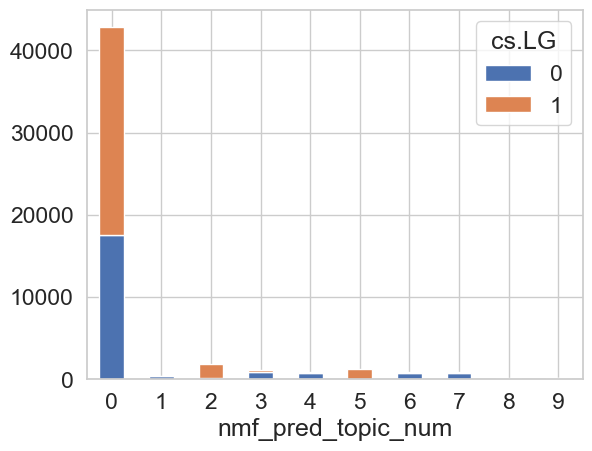

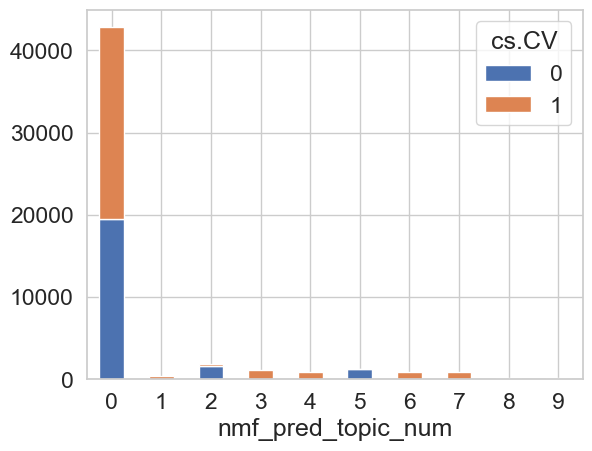

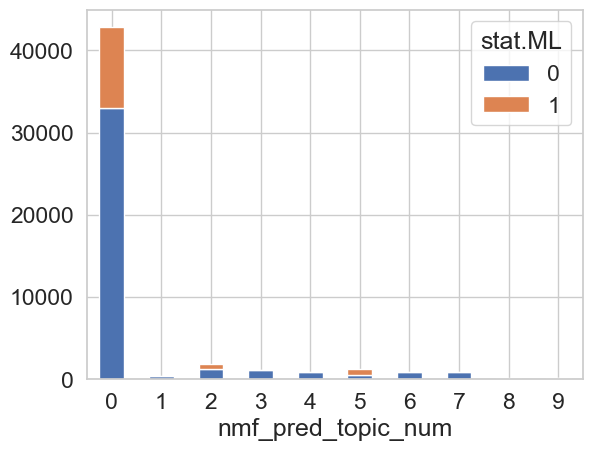

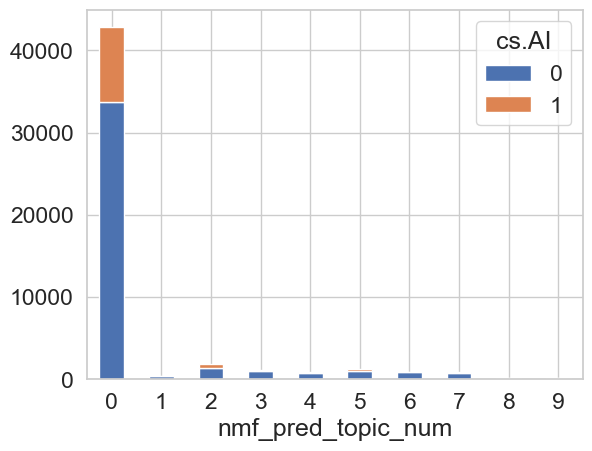

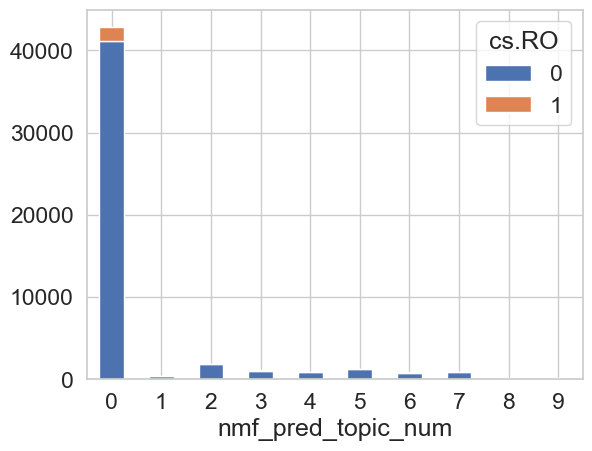

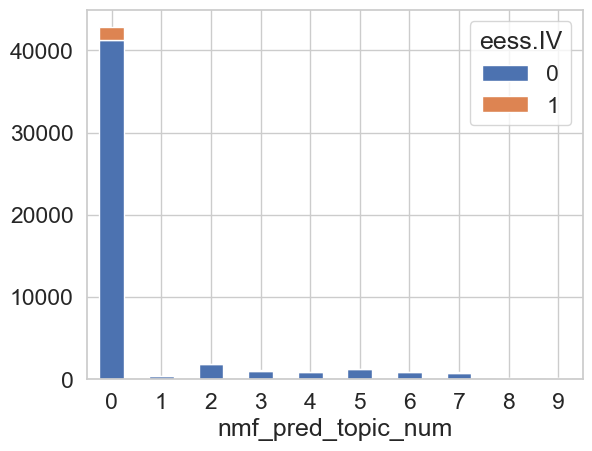

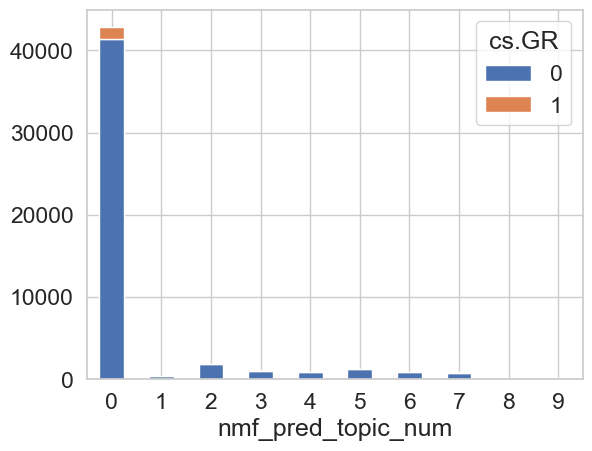

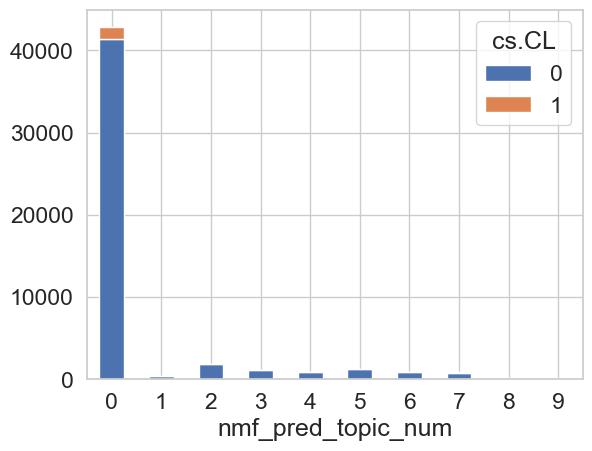

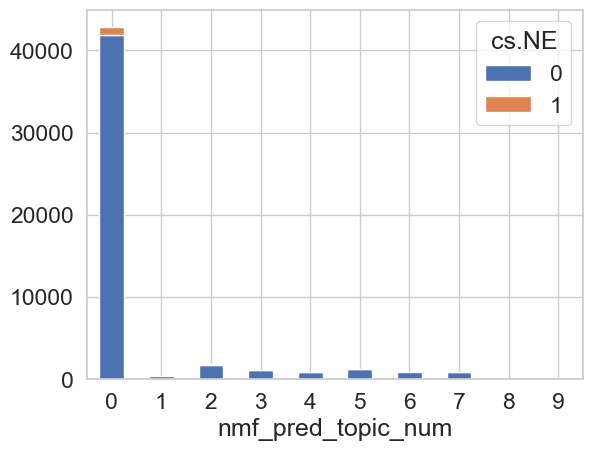

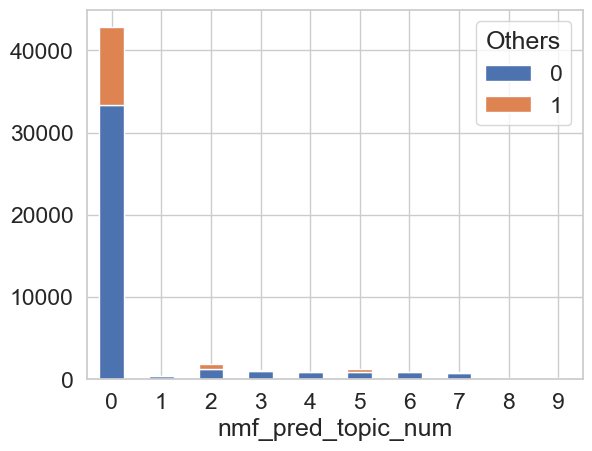

In [118]:
# Evaluate the Categories
df_new = df.copy()

# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in W_lsa_text_matrix]

# Add to the df
df_new['nmf_pred_topic_num'] = predicted_topics

# Create Crosstab
for _, col in enumerate(df_new.columns[4:14]):
    print("Original Topic -", col)
    chart_df = pd.crosstab(df_new["nmf_pred_topic_num"], df_new[col],  dropna=False)
    display(chart_df.plot(kind="bar", stacked=True, rot=0))
    print("Counts:")
    display(pd.crosstab(df_new[col], df_new["nmf_pred_topic_num"], dropna=False))
    print("Column %:")
    display(pd.crosstab(df_new[col], df_new["nmf_pred_topic_num"], dropna=False, normalize='columns').style.format("{:.0%}"))
    print("Total %:")
    display(pd.crosstab(df_new[col], df_new["nmf_pred_topic_num"], dropna=False, normalize='all').style.format("{:.0%}"))
    print('\n')

### Fitting an LDA Model - LDA

In [117]:
# Fit your LDA model here

lda_text_model = LatentDirichletAllocation(n_components=10, random_state=0)
W_lda_text_matrix = lda_text_model.fit_transform(tfidf_text_vectors)
H_lda_text_matrix = lda_text_model.components_

In [119]:

# Call `display_topics` on your fitted model here
display_topics(lda_text_model, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=5)


Topic 00
  ticket (0.25)
  str (0.23)
  lottery (0.20)
  nodule (0.19)
  ail (0.18)

Topic 01
  plate (0.45)
  license (0.37)
  shapelets (0.32)
  charging (0.30)
  shapelet (0.26)

Topic 02
  learning (0.69)
  reinforcement (0.68)
  policy (0.60)
  rl (0.52)
  algorithm (0.45)

Topic 03
  data (0.56)
  learning (0.42)
  models (0.39)
  model (0.35)
  time (0.35)

Topic 04
  image (0.97)
  adversarial (0.70)
  point (0.70)
  images (0.56)
  generation (0.51)

Topic 05
  rain (0.64)
  crop (0.52)
  shadow (0.45)
  plant (0.29)
  weather (0.27)

Topic 06
  object (0.82)
  detection (0.71)
  segmentation (0.48)
  video (0.44)
  image (0.44)

Topic 07
  3d (1.44)
  depth (1.20)
  pose (0.69)
  estimation (0.67)
  point (0.54)

Topic 08
  molecular (1.88)
  molecules (1.42)
  federated (1.18)
  fl (1.12)
  chemical (0.90)

Topic 09
  graph (1.16)
  learning (0.78)
  data (0.45)
  representation (0.42)
  graphs (0.40)


Original Topic - cs.LG


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.LG,,,,,,,,
0,1,669,4418,2449,9899,2784,1,1213
1,2,8899,9940,1197,2069,477,0,6318


Column %:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.LG,,,,,,,,
0,33%,7%,31%,67%,83%,85%,100%,16%
1,67%,93%,69%,33%,17%,15%,0%,84%


Total %:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.LG,,,,,,,,
0,0%,1%,9%,5%,20%,6%,0%,2%
1,0%,18%,20%,2%,4%,1%,0%,13%




Original Topic - cs.CV


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.CV,,,,,,,,
0,2,8762,7917,281,260,27,0,5106
1,1,806,6441,3365,11708,3234,1,2425


Column %:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.CV,,,,,,,,
0,67%,92%,55%,8%,2%,1%,0%,68%
1,33%,8%,45%,92%,98%,99%,100%,32%


Total %:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.CV,,,,,,,,
0,0%,17%,16%,1%,1%,0%,0%,10%
1,0%,2%,13%,7%,23%,6%,0%,5%




Original Topic - stat.ML


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
stat.ML,,,,,,,,
0,3,4553,10996,3369,11723,3201,1,5403
1,0,5015,3362,277,245,60,0,2128


Column %:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
stat.ML,,,,,,,,
0,100%,48%,77%,92%,98%,98%,100%,72%
1,0%,52%,23%,8%,2%,2%,0%,28%


Total %:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
stat.ML,,,,,,,,
0,0%,9%,22%,7%,23%,6%,0%,11%
1,0%,10%,7%,1%,0%,0%,0%,4%




Original Topic - cs.AI


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.AI,,,,,,,,
0,3,6677,11308,3158,10615,3012,1,5313
1,0,2891,3050,488,1353,249,0,2218


Column %:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.AI,,,,,,,,
0,100%,70%,79%,87%,89%,92%,100%,71%
1,0%,30%,21%,13%,11%,8%,0%,29%


Total %:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.AI,,,,,,,,
0,0%,13%,22%,6%,21%,6%,0%,11%
1,0%,6%,6%,1%,3%,0%,0%,4%




Original Topic - cs.RO


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.RO,,,,,,,,
0,3,9033,14147,3616,11371,2977,1,7151
1,0,535,211,30,597,284,0,380


Column %:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.RO,,,,,,,,
0,100%,94%,99%,99%,95%,91%,100%,95%
1,0%,6%,1%,1%,5%,9%,0%,5%


Total %:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.RO,,,,,,,,
0,0%,18%,28%,7%,23%,6%,0%,14%
1,0%,1%,0%,0%,1%,1%,0%,1%




Original Topic - eess.IV


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
eess.IV,,,,,,,,
0,2,9523,13677,3346,11430,3119,0,7458
1,1,45,681,300,538,142,1,73


Column %:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
eess.IV,,,,,,,,
0,67%,100%,95%,92%,96%,96%,0%,99%
1,33%,0%,5%,8%,4%,4%,100%,1%


Total %:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
eess.IV,,,,,,,,
0,0%,19%,27%,7%,23%,6%,0%,15%
1,0%,0%,1%,1%,1%,0%,0%,0%




Original Topic - cs.GR


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.GR,,,,,,,,
0,3,9489,14114,3291,11843,2503,1,7477
1,0,79,244,355,125,758,0,54


Column %:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.GR,,,,,,,,
0,100%,99%,98%,90%,99%,77%,100%,99%
1,0%,1%,2%,10%,1%,23%,0%,1%


Total %:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.GR,,,,,,,,
0,0%,19%,28%,7%,24%,5%,0%,15%
1,0%,0%,0%,1%,0%,2%,0%,0%




Original Topic - cs.CL


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.CL,,,,,,,,
0,3,9480,13826,3317,11702,3260,1,7255
1,0,88,532,329,266,1,0,276


Column %:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.CL,,,,,,,,
0,100%,99%,96%,91%,98%,100%,100%,96%
1,0%,1%,4%,9%,2%,0%,0%,4%


Total %:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.CL,,,,,,,,
0,0%,19%,27%,7%,23%,6%,0%,14%
1,0%,0%,1%,1%,1%,0%,0%,1%




Original Topic - cs.NE


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.NE,,,,,,,,
0,2,9322,13936,3606,11877,3253,1,7304
1,1,246,422,40,91,8,0,227


Column %:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.NE,,,,,,,,
0,67%,97%,97%,99%,99%,100%,100%,97%
1,33%,3%,3%,1%,1%,0%,0%,3%


Total %:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
cs.NE,,,,,,,,
0,0%,19%,28%,7%,24%,6%,0%,15%
1,0%,0%,1%,0%,0%,0%,0%,0%




Original Topic - Others


<AxesSubplot: xlabel='nmf_pred_topic_num'>

Counts:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
Others,,,,,,,,
0,3,6257,9887,3201,11193,3032,1,6073
1,0,3311,4471,445,775,229,0,1458


Column %:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
Others,,,,,,,,
0,100%,65%,69%,88%,94%,93%,100%,81%
1,0%,35%,31%,12%,6%,7%,0%,19%


Total %:


nmf_pred_topic_num,0,2,3,4,6,7,8,9
Others,,,,,,,,
0,0%,12%,20%,6%,22%,6%,0%,12%
1,0%,7%,9%,1%,2%,0%,0%,3%


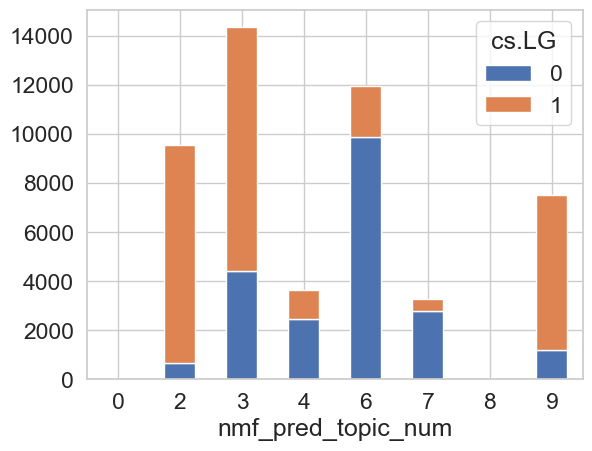

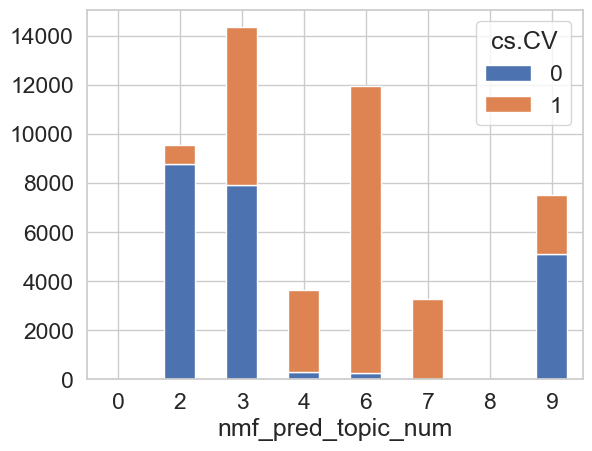

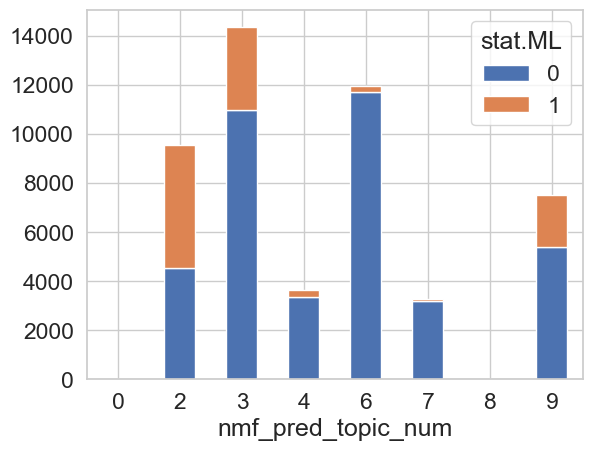

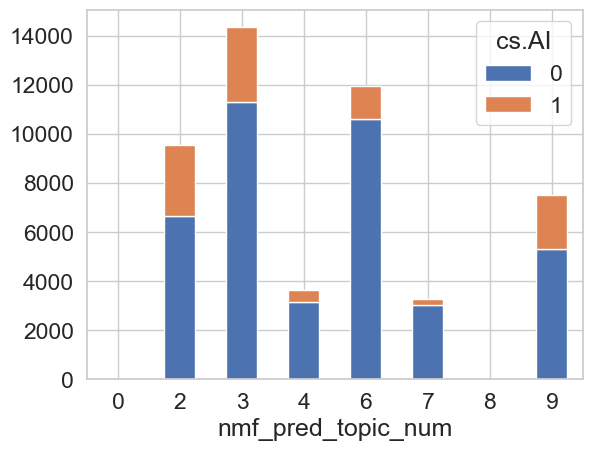

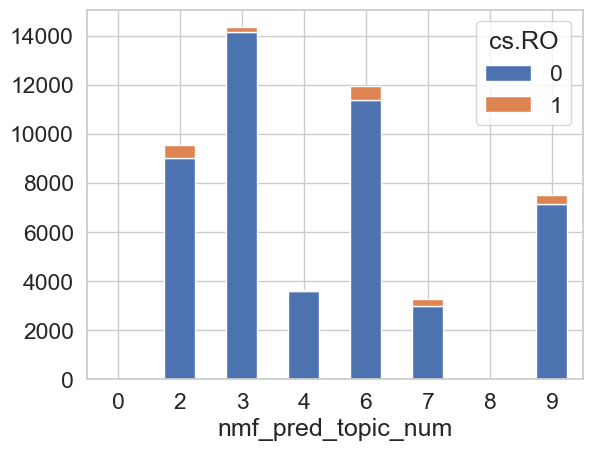

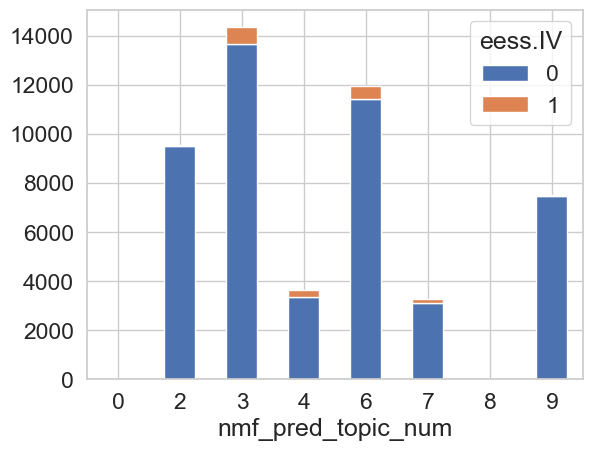

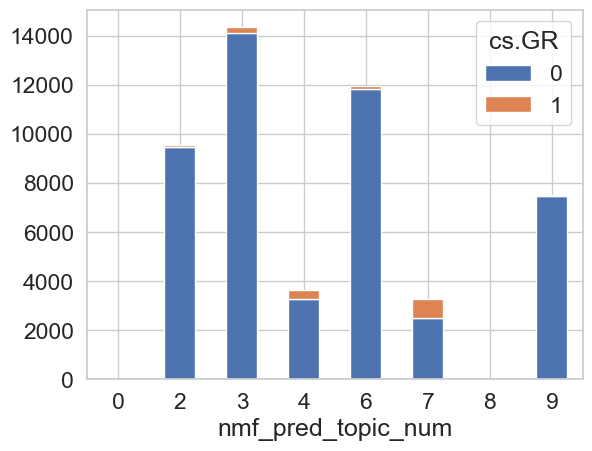

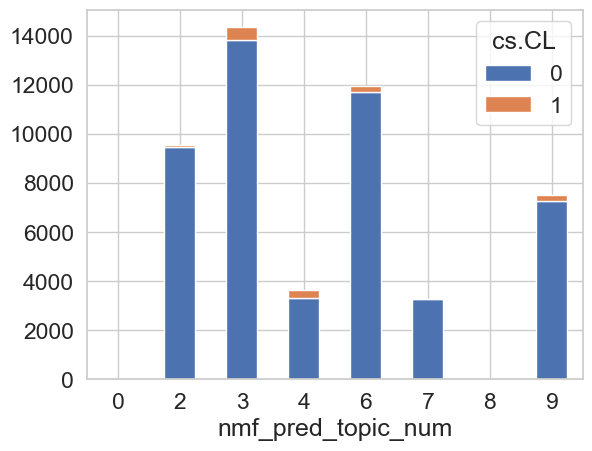

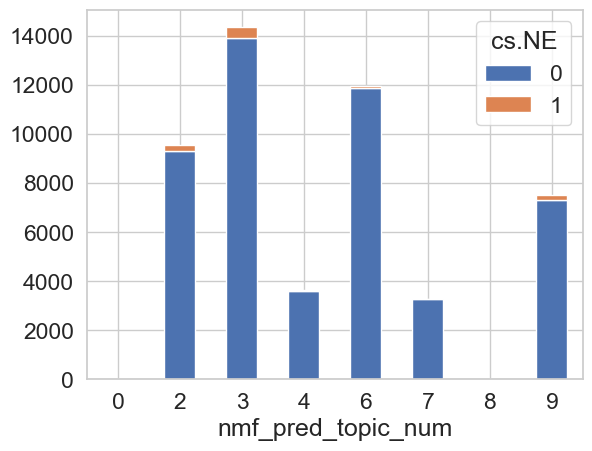

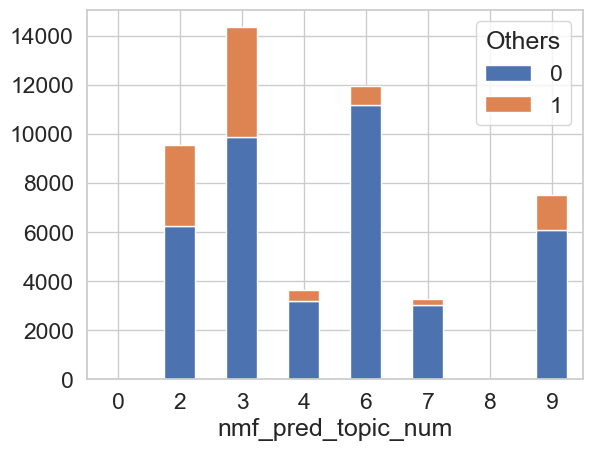

In [120]:
# Evaluate the Categories
df_new = df.copy()

# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in W_lda_text_matrix]

# Add to the df
df_new['nmf_pred_topic_num'] = predicted_topics

# Create Crosstab
for _, col in enumerate(df_new.columns[4:14]):
    print("Original Topic -", col)
    chart_df = pd.crosstab(df_new["nmf_pred_topic_num"], df_new[col],  dropna=False)
    display(chart_df.plot(kind="bar", stacked=True, rot=0))
    print("Counts:")
    display(pd.crosstab(df_new[col], df_new["nmf_pred_topic_num"], dropna=False))
    print("Column %:")
    display(pd.crosstab(df_new[col], df_new["nmf_pred_topic_num"], dropna=False, normalize='columns').style.format("{:.0%}"))
    print("Total %:")
    display(pd.crosstab(df_new[col], df_new["nmf_pred_topic_num"], dropna=False, normalize='all').style.format("{:.0%}"))
    print('\n')